# Introduction
I will be working on a dataset gotten from https://datasets.simula.no/depresjon/#download. The data was harvested from smart actigraph wrist watch belonging to 55 different individuals. This actigraph wristwatch takes patients health details such as patients motor activity, sleep/inactivity, heart rate, etc. In this case, the data contains the following columns:
- timestamp (one minute intervals)
- date (date of measurement)
- activity (activity measurement from the actigraph watch). 

The data set is already separated into two folders, both containing actigraph data (csv files) of patients collected over time. The first group is stored in a folder called "condition" which contains actigraph data of 23 depressed patients who suffer from either bipolar/unipolar while the second folder "control" contains actigraph data of 32 mormal people with no signs of depression.

There is another csv file containing the following columns; 
- number (patient identifier), 
- days (number of days of measurements), 
- gender (1 or 2 for female or male), 
- age (age in age groups), 
- afftype (1: bipolar II, 2: unipolar depressive, 3: bipolar I), 
- melanch (1: melancholia, 2: no melancholia), 
- inpatient (1: inpatient, 2: outpatient), 
- edu (education grouped in years), 
- marriage (1: married or cohabiting, 2: single), 
- work (1: working or studying, 2: unemployed/sick leave/pension), 
- madrs1 (MADRS score when measurement started), madrs2 (MADRS when measurement stopped). 

The essence of this work is to mix both data together and see if it will be possible to separate the mixed data back into their correct category using binary classification.

Let us begin.

### Import Necessary Libraries

In [66]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import seaborn as sns
from datetime import datetime
import os
import random
from keras.preprocessing import sequence

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras import backend as K

In [2]:
# Check if GPU is available

if tf.test.gpu_device_name():
    print('Default GPU Device Details: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install Tensorflow that supports GPU")

Default GPU Device Details: /device:GPU:0


# Data Preparation and cleaning

In [3]:
def get_data(folder, start = 0, stop = 1440, label = 1):
    """This function takes three arguments which are the folder to be fetched 
    from, the duration/number of minutes to observe. Default is 1440 
    as 1440 minutes make one day and then the label of the observation. 
    The main idea is to use a numpy array to map the activity levels to a category
    We are just saying... People who have their day like this (1440 minutes actigraph
    data -that is the features X) are depressed or ok (That is the label y 
    which can be 1 or 0 but 1 by default depending on the folder we are examining).)
    """
    
    # Construct the file path using the folder name
    folder = 'data/' + str(folder)
    FileNames = os.listdir(folder)
    
    # initialise lists which will contain an array of the activities of each patient and their label.
    X = []
    y = []

    # iterate through each file in the above file path
    for fileName in FileNames:
        
        # read each file
        df = pd.read_csv(folder + '/' + str(fileName))
        
        # get all unique dates 
        dates = df['date'].unique()
        
        # make a list container for activity levels
        activityLevelsPerDay = []
        
        # for each unique date
        for date in dates:
            
            # if the observations are up to one full day(1440 mins)
            if len(df[df['date']==date]) == 1440:
                
                # fetch only activity column
                temp = pd.DataFrame(df[df['date']==date]).drop(columns=['timestamp','date'])
                
                # store the activity column inside our list container
                activityLevelsPerDay.append(temp)
                
        # convert the activity levels into a numpy array suitable for machine learning.        
        for dailyActivityLevel in activityLevelsPerDay:
            activityVector = np.array(dailyActivityLevel["activity"], dtype='float32')
            
            # append this activity numpy array to the initial list and generate a 
            # corresponding label too.
            if len(activityVector) == 1440:
                X.append(activityVector[start : stop])
                y.append(np.array(label, dtype='float32'))
    
    # return the array
    return X, y


In [12]:
# Fetch data for both classes and label them using the function created above.

condition_data = get_data(folder='condition', label=1)
X_condition = condition_data[0]
y_condition = condition_data[1]

control_data = get_data(folder='control', label=0)
X_control = control_data[0]
y_control = control_data[1]

Let us look at the size of the data

In [5]:
print("Data of people with depressive condition are", len(X_condition), "rows \
while those of the normal people are", len(X_control), "rows.")

Data of people with depressive condition are 359 rows while those of the normal people are 670 rows.


# Data Visualisation


I will select a sample from the condition data and plot it.

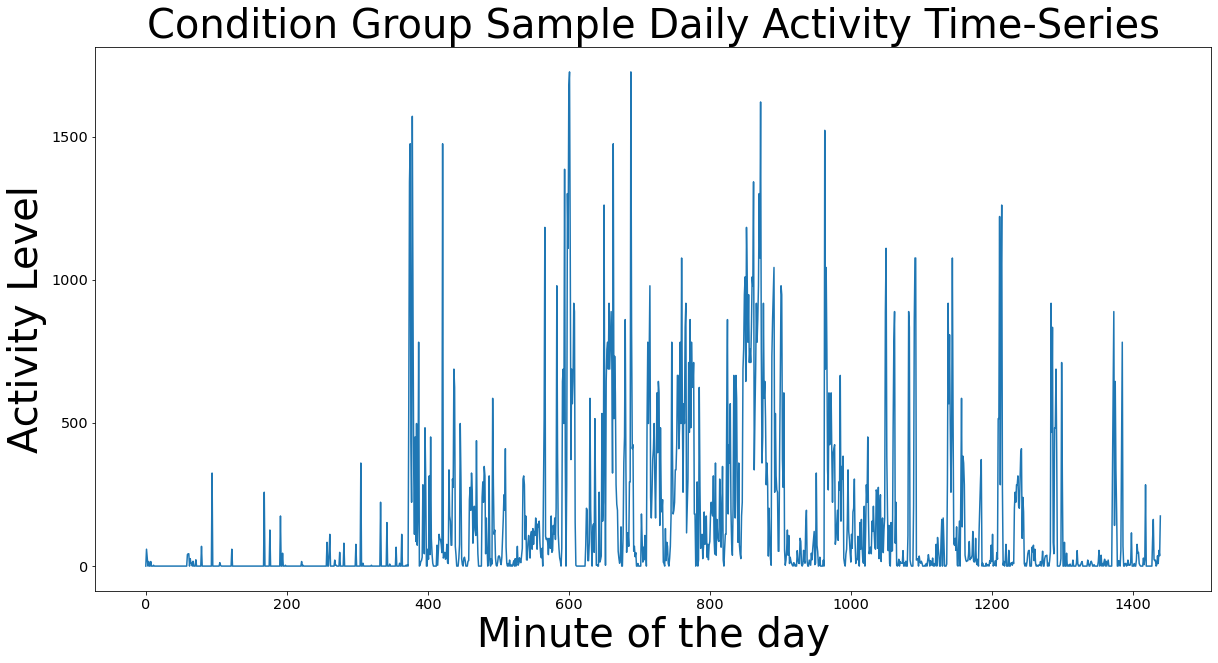

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(X_condition[0])
plt.title('Condition Group Sample Daily Activity Time-Series', fontsize=40)
plt.ylabel('Activity Level', fontsize=40)
plt.xlabel('Minute of the day', fontsize=40)
plt.grid(False)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)

# save image to include in pdf
plt.savefig('Condition Group Sample Daily Activity Time-Series.jpg') 
plt.show()

Also select a sample from the control data and plot it.

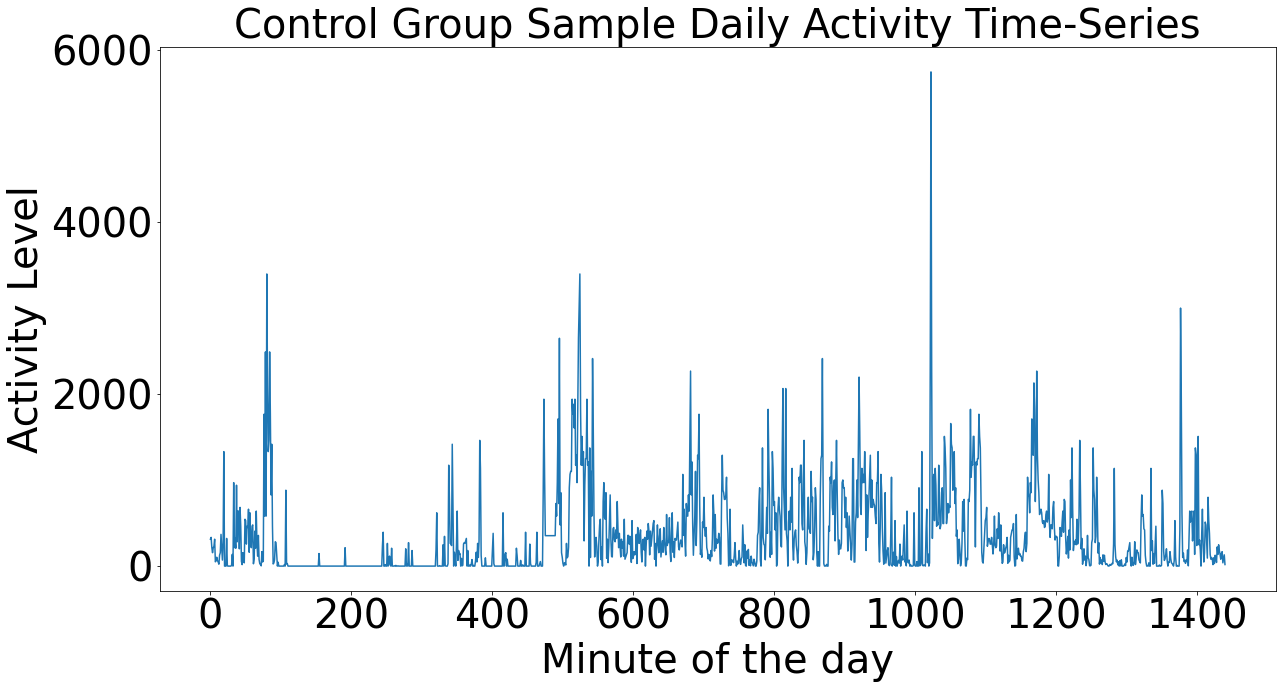

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(X_control[0])
plt.title('Control Group Sample Daily Activity Time-Series', fontsize=40)
plt.ylabel('Activity Level', fontsize=40)
plt.xlabel('Minute of the day', fontsize=40)
plt.grid(False)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)

plt.savefig('Control Group Sample Daily Activity Time-Series.jpg')
plt.show()

### Observation:
From my observation, at night (that is first half of the day, between 0 and 720 minutes), the one with depression is more active than the normal person. Although this seems true using the visualisation from above, but the visualisation is only from one sample and it would be unfair to generalise. I am going to show more visualisations below to confirm my observation by getting the average sleep pattern of each class and ploting the same graph. Thereafter, I will plot both graphs on one plot for easier comparison.

#### Get average for condition

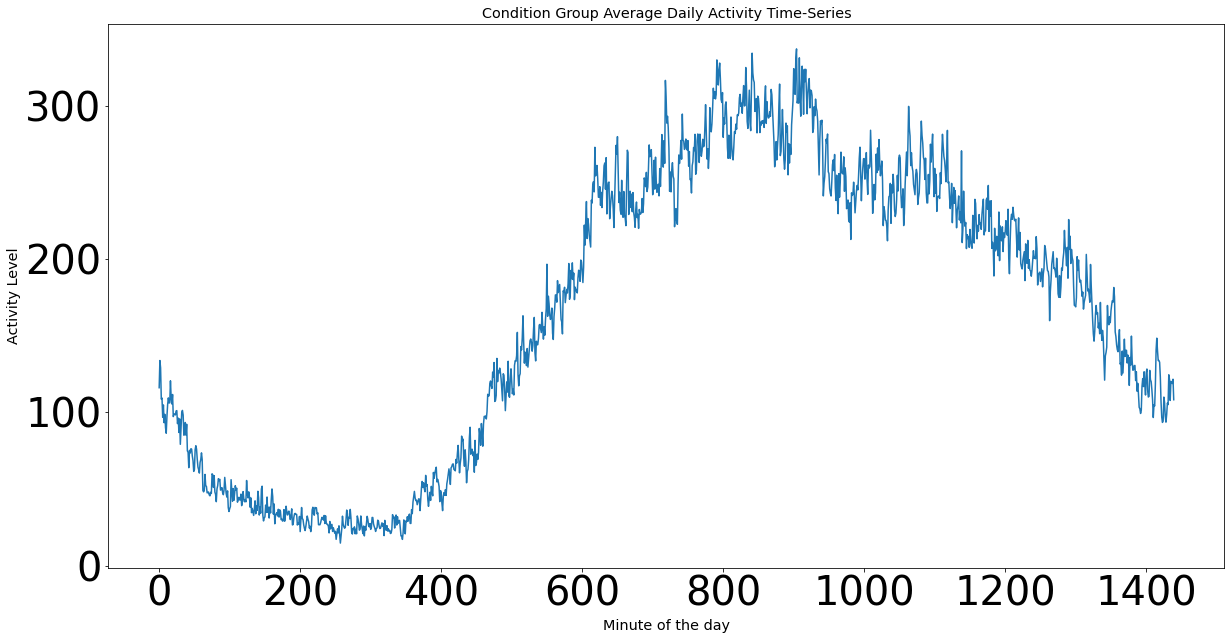

In [13]:
# Get average for condition
condition_sum_vector = X_condition[0]
for x in range(1, len(X_condition)):
    condition_sum_vector += X_condition[x]
condition_avg_vector = condition_sum_vector / len(X_condition)

# plot
plt.figure(figsize=(20, 10))
plt.plot(condition_avg_vector)
plt.title('Condition Group Average Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)

plt.savefig('Condition Group Average Daily Activity Time-Series.png')
plt.show()

#### Get average for control

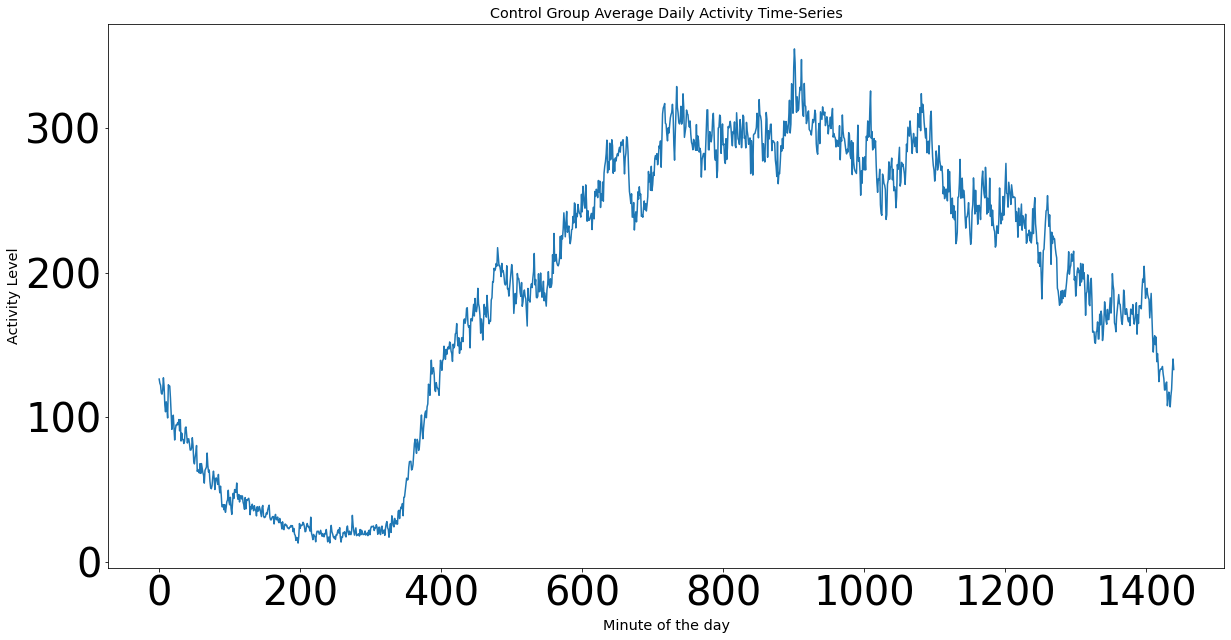

<Figure size 1080x360 with 0 Axes>

In [14]:
# Get average for control
control_sum_vector = X_control[0]
for x in range(1, len(X_control)):
    control_sum_vector += X_control[x]
control_sum_vector = control_sum_vector / len(X_control)

# Plot
plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector)
plt.title('Control Group Average Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Control Group Average Daily Activity Time-Series.png')

#### Compare side by side
Now let us superimpose both graphs and compare.

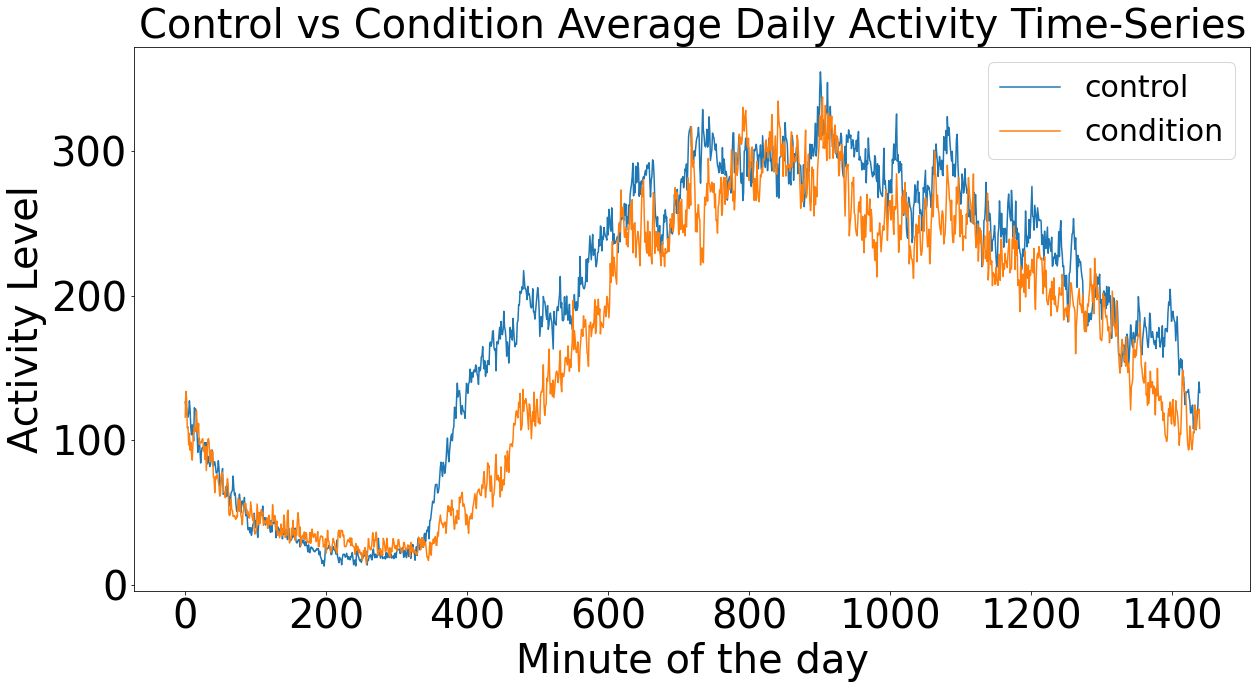

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector, label='control')
plt.plot(condition_avg_vector, label='condition')
plt.title('Control vs Condition Average Daily Activity Time-Series', fontsize=40)

plt.ylabel('Activity Level', fontsize=40)
plt.xlabel('Minute of the day', fontsize=40)
plt.grid(False)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)
plt.legend(fontsize=30)
plt.grid(False)

plt.savefig('Control vs Condition Average Daily Activity Time-Series.png')
plt.show()

#### Visualise half day
From the above, it is possible to separate the data in the first 720 minutes, precisely between 350 and 600 minutes which happens to be in the night. I will zoom in my visualisation below to further examine the data at night time, that is in the first half (720 minutes) of the day.

In [16]:
# get data for the first 720 minutes only.
condition_night = get_data(folder='condition', stop=720)
X_condition_night = condition_night[0]

control_night = get_data(folder='control', stop=720)
X_control_night = control_night[0]


##### Visual of people in the depression group

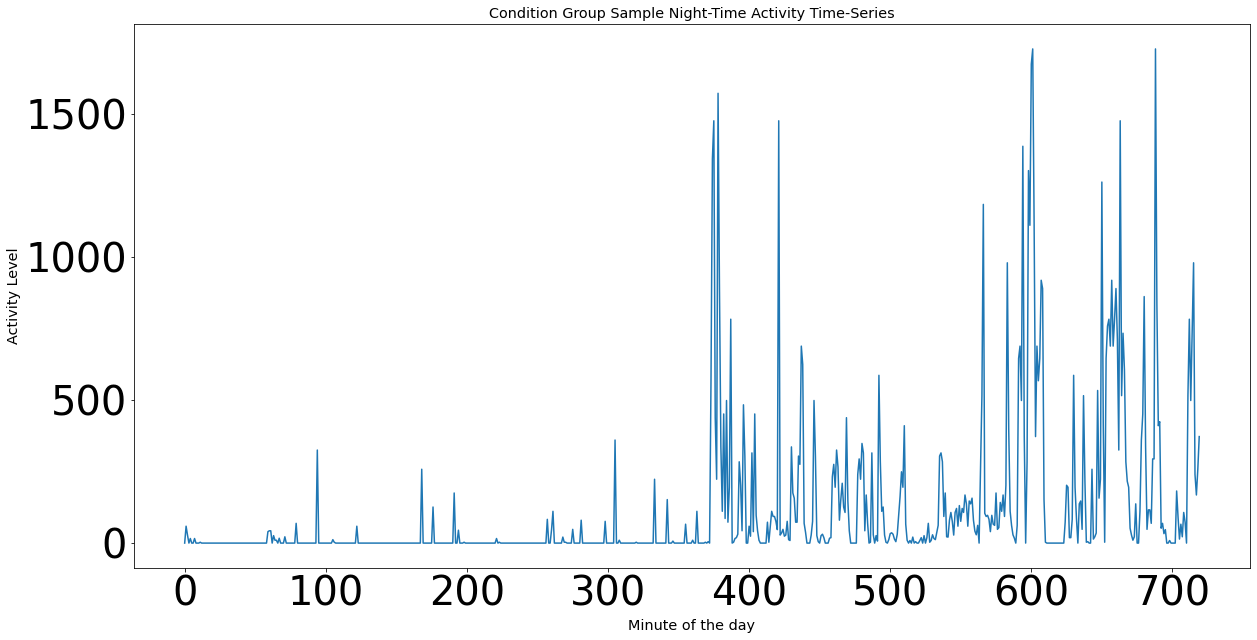

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(X_condition_night[0])
plt.title('Condition Group Sample Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.savefig('Condition Group Sample Night-Time Activity Time-Series.png')
plt.show()

##### Sample visual of people in the control group

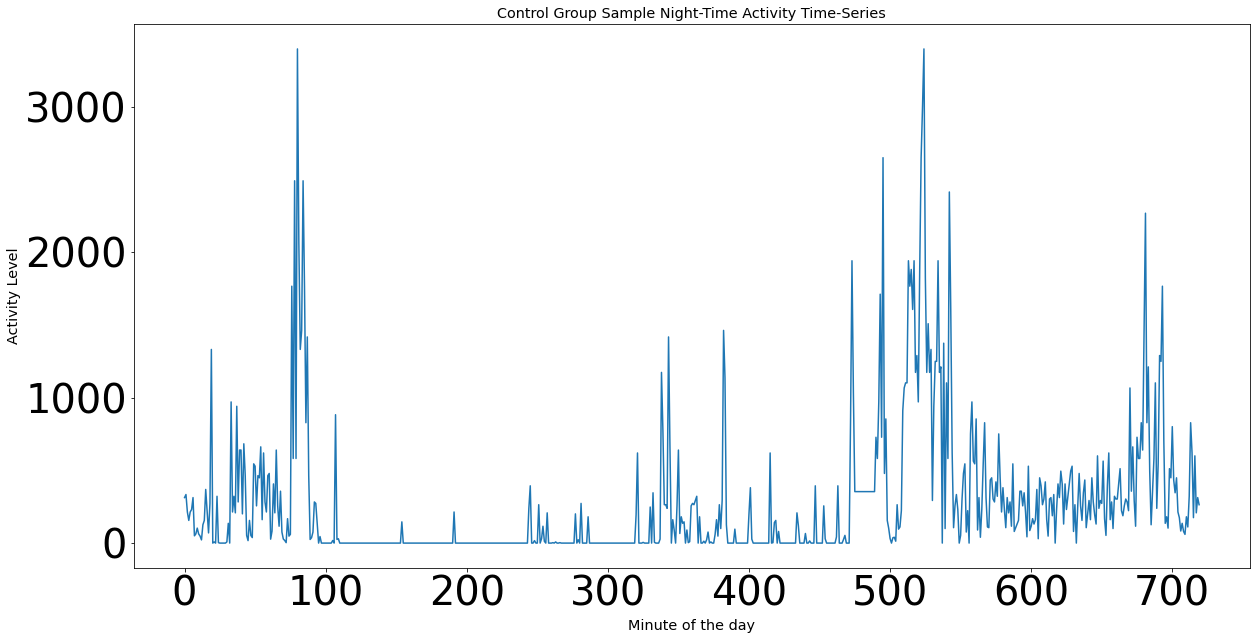

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(X_control_night[0])
plt.title('Control Group Sample Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.savefig('Control Group Sample Night-Time Activity Time-Series.png')
plt.show()

#### Average of daytime activity for depressed people.
From the last two graphs above, viewing only the data at night time enables us to tell the difference more clearly. We will go ahead to find the average and plot again in like manner.

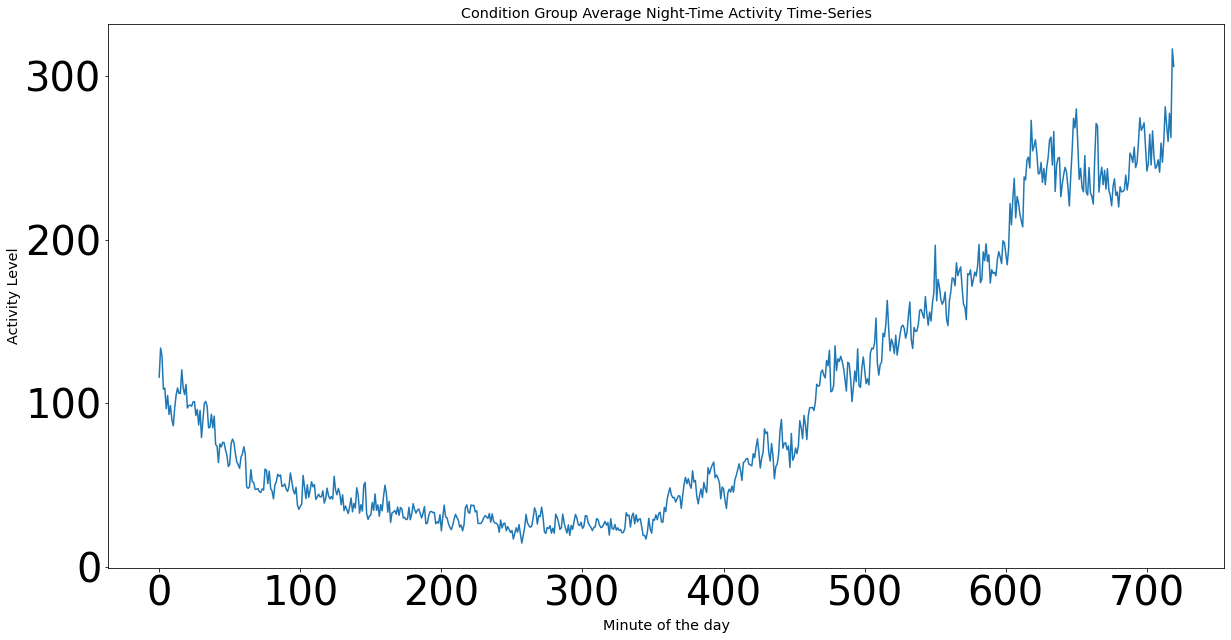

<Figure size 1080x360 with 0 Axes>

In [19]:
condition_sum_vector = X_condition_night[0]
for x in range(1, len(X_condition_night)):
    condition_sum_vector += X_condition_night[x]
condition_avg_vector = condition_sum_vector / len(X_condition_night)

plt.figure(figsize=(20, 10))
plt.plot(condition_avg_vector)
plt.title('Condition Group Average Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Condition Group Average Night-Time Activity Time-Series.png')

#### Average of daytime activity for normal people.

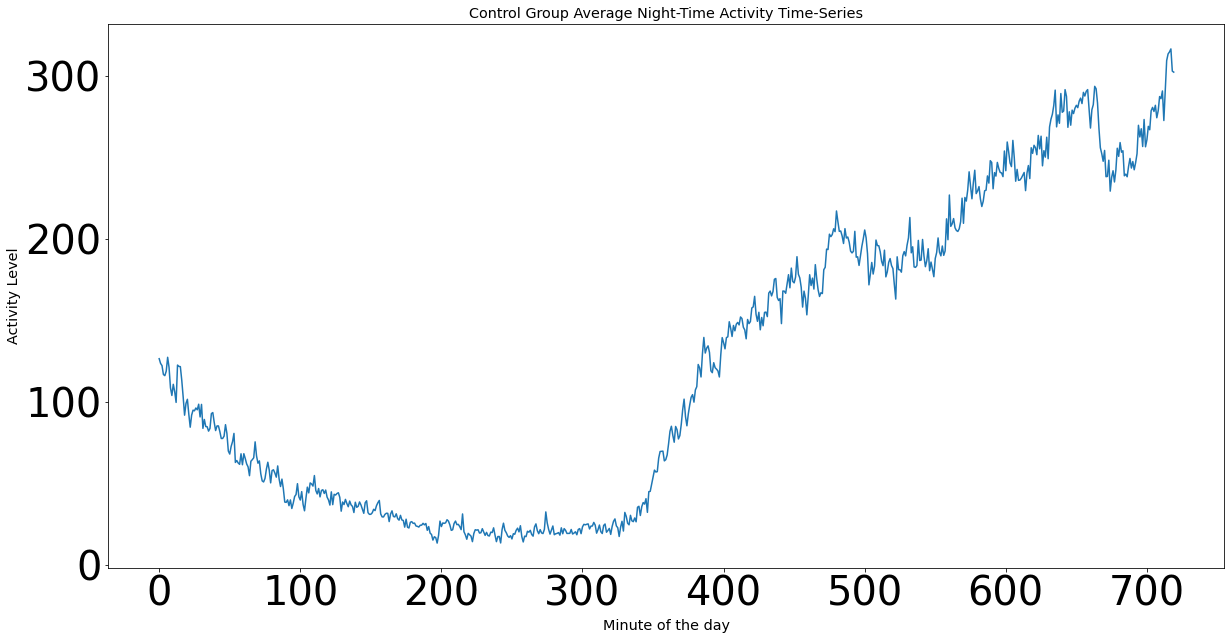

<Figure size 1080x360 with 0 Axes>

In [20]:
control_sum_vector = X_control_night[0]
for x in range(1, len(X_control_night)):
    control_sum_vector += X_control_night[x]
control_sum_vector = control_sum_vector / len(X_control_night)

plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector)
plt.title('Control Group Average Night-Time Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.grid(False)
plt.show()
plt.savefig('Control Group Average Night-Time Activity Time-Series.png')

#### Superimpose for comparison

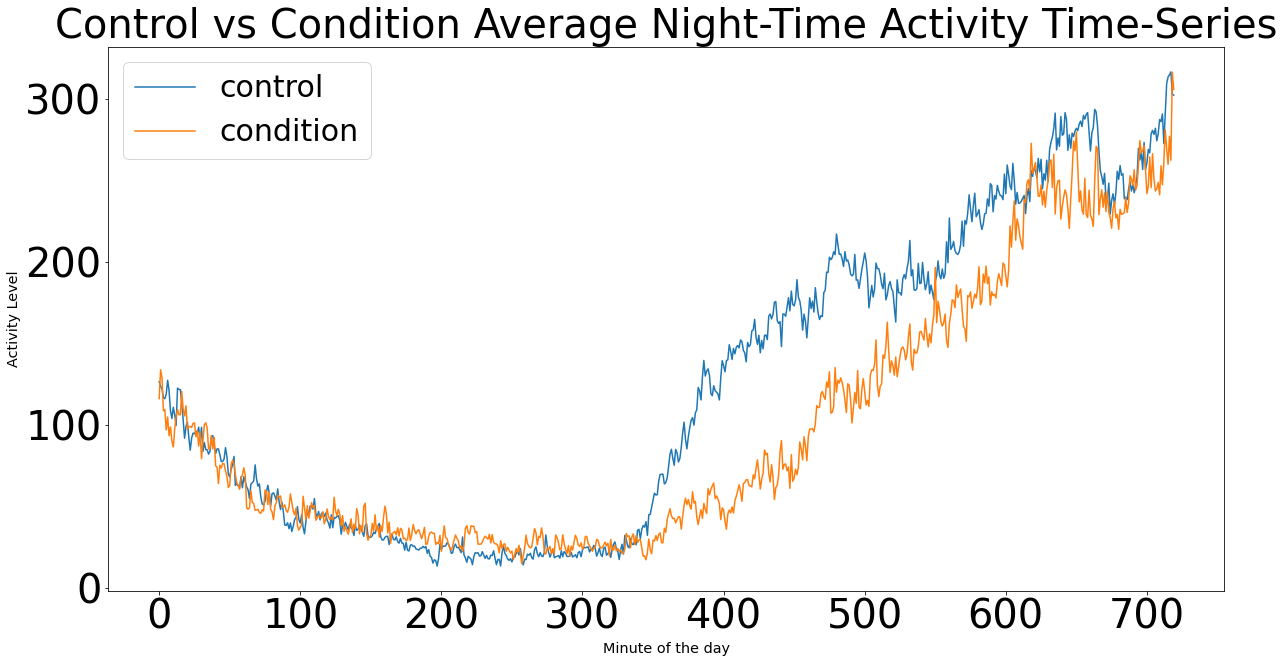

In [22]:
plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector, label='control')
plt.plot(condition_avg_vector, label='condition')
plt.title('Control vs Condition Average Night-Time Activity Time-Series', fontsize=40)
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.legend(fontsize=30)
plt.grid(False)
plt.savefig('Control vs Condition Average Night-Time Activity Time-Series.png')
plt.show()

So, as far as my eyes can see on the 2D graphical space, it seems that a model can leverage on the deferences as seen between 300 and 600 minutes to classify our model correctly.

Now, let us combine our data and see if we can truly separate them.

In [6]:
# Get data of the depressed patients and give them a label of 1
condition = get_data(folder='condition', label=1)
X_condition = condition[0]
y_condition = condition[1]

# Get data of the normal people and give them a label of 0
control = get_data(folder='control', label=0)
X_control = control[0]
y_control = control[1]

# Add both data together
X_condition.extend(X_control)
X = X_condition


y_condition.extend(y_control)
y = y_condition

In [29]:
len(X_control)

670

In [26]:
len(y_condition)

1029

In [18]:
print(len(X[0]))
print(len(y))

1440
1029


From the above, we have 1029 observtions.

In [19]:
print(np.unique(y))

[0. 1.]


In [8]:
# For reproducibility.
seed = 7

Shuffle the combined dataset

In [9]:
# Here, I tie each observation to a lable using zip.
combinedDict = list(zip(X, y))

# Then I shuffle it
random.Random(seed).shuffle(combinedDict)

# And isolate the X and the y once more 
X[:], y[:] = zip(*combinedDict)

Make them into a Numpy array suitable for machine learning algorithms

In [10]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')
# X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [11]:
X.shape

(1029, 1440)

In [12]:
X

array([[ 81.,   5.,  36., ...,  64.,   0.,  34.],
       [ 10.,   4.,  32., ..., 212., 397., 112.],
       [161.,   0.,   0., ...,   0.,   0., 394.],
       ...,
       [  8.,   8.,   8., ...,   3.,   3.,   3.],
       [147.,   0.,   5., ...,   7.,  59.,   0.],
       [  3.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

In [13]:
# create cross-validation splits
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [26]:
print(np.unique(y))
print(len(X))

[0. 1.]
1029


I used the function bellow to perform a grid search when choosing the best C and gamma parameters for my SVM model

In [27]:
# ## C = [2**(1 + (n/100)) for n in range(-1025, 1025, 25)]
# C = np.arange(0.79, 0.82, 0.0001)
# bestC = {}
# i = 0
# l = len(C)
# accuracy = []
# for c in C:
#     i += 1
#     SupportVectorClassModel = SVC(kernel='rbf', C=c)
#     for train, test in kfold.split(X, y):
#         SupportVectorClassModel.fit(X[train], y[train])
#         y_pred = SupportVectorClassModel.predict(X[test])
#         acc = accuracy_score(y[test], y_pred)*100
#         accuracy.append(acc)
#         progress = str(round(((i * 100)/(l)), 1)) + "%"
#         
#     if i % 10 == 0:
#         print("Accuracy = %-20s C = %-20s progress = %-20s" % (acc, c, progress))
# 
#     if acc > 73:
#         bestC[acc] = c
#         cm = confusion_matrix(y[test], y_pred)
#         print("-----------------------------------Accuracy =", acc, "\nC =", c)
#         print(cm)
# 
# 
# 
# print("Maximum accuracy achieved is", max(bestC, key=int), "with c =", bestC[max(bestC, key=int)])
# print("Training samples:", len(X[train]), "\nwhile test samples:", len(X[test]))
# acc = round((sum(accuracy)/len(accuracy)), 4)
# print(acc)
# 

In [28]:
accuracy = []
SupportVectorClassModel = SVC(kernel='rbf', C=0.8, random_state=seed)
for train, test in kfold.split(X, y):
    SupportVectorClassModel.fit(X[train], y[train])
    y_pred = SupportVectorClassModel.predict(X[test])
    acc = accuracy_score(y[test], y_pred)*100
    accuracy.append(acc)
    print("Accuracy = %-20s" % (acc))
    cm = confusion_matrix(y[test], y_pred)
    print(cm)
    print(classification_report(y[test], y_pred))


print("Training samples:", len(X[train]), "\nwhile test samples:", len(X[test]))
acc = round((sum(accuracy)/len(accuracy)), 4)
print("The average accuracy score after cross validation is", acc)

Accuracy = 78.64077669902912   
[[59  8]
 [14 22]]
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        67
         1.0       0.73      0.61      0.67        36

    accuracy                           0.79       103
   macro avg       0.77      0.75      0.75       103
weighted avg       0.78      0.79      0.78       103

Accuracy = 78.64077669902912   
[[60  7]
 [15 21]]
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85        67
         1.0       0.75      0.58      0.66        36

    accuracy                           0.79       103
   macro avg       0.78      0.74      0.75       103
weighted avg       0.78      0.79      0.78       103

Accuracy = 75.72815533980582   
[[57 10]
 [15 21]]
              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82        67
         1.0       0.68      0.58      0.63        36

    accuracy                 

Now, I want to get a similar code which I can apply to other algorithms as well and with single averaged metrics values instead of having them for each individual cross validation.

Let us do that in the code below.

In [29]:
def get_metrics(y_true, y_pred):
    """This function returns a list of dictionaries containing the required evaluation metrics"""
    result = []
    label = [0, 1]
    # the label created above represents category 1 or 0 and is used to get evaluation metrics for
    # both classes individually. label 0 represents not_depressed, and 1 represents depressed.
    
    for pos_label in label:
        metrics = {}
        
        # get confusion matrix prediction values
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # fetch the matrics
        prec = precision_score(y_true, y_pred, pos_label=pos_label)
        rec = recall_score(y_true, y_pred, pos_label=pos_label)
        acc = accuracy_score(y_true, y_pred)
        spec = tn / (tn + fp)
        mcc = matthews_corrcoef(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, labels=None, pos_label=pos_label)
        
        # attach the metrics to dictionary
        metrics['prec'] = round(prec, 3)
        metrics['rec'] = round(rec, 3)
        metrics['acc'] = round(acc, 3)
        metrics['spec'] = round(spec, 3)
        metrics['mcc'] = round(mcc, 3)
        metrics['f1'] = round(f1, 3)
        
        # put the dictionary into a list.
        result.append(metrics)
        
    return result




def get_average(result, metric, n_splits, category=1):
    """ 'result' is a list of dictionary (gotten from the function multiple outputs of 'get_metrics()' 
    created above) which stores metrics derived accross several cross validations. When cross validation
    of n_splits happens, this function returns the average of a paticular 'metric' appearing in 'result'. 
    Specifying category = 1 or 0 gets the average matrix for a particular category (depressed or non depressed)"""
    
    sum = 0
    for i in range(n_splits):
        sum += result[i][category][str(metric)]
    return sum/(n_splits)


def cross_validation_(algorithm, n_splits = 10):
    """This function does kfold validation on a model/algorithm, trains it and returns the overall weighted average"""
    
    kfold = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    # kfold declaration
    
    metrics_container = []
    # create a container to put in the resulting metrics from each crossvalidation
    
    # cross validation happens
    for train, test in kfold.split(X, y):
        
        # train the model
        algorithm.fit(X[train], y[train])
        
        # predict
        y_pred = algorithm.predict(X[test])
        
        # get the metrics and put into the metrics_container
        metric = get_metrics(y[test], y_pred)
        metrics_container.append(metric)
        
        
    combine_metric = {}

    # fish out the average metrics of both classes 0 and 1 and get their averages too.
    depressed_prec = get_average(result=metrics_container, metric='prec', n_splits=n_splits, category=1)
    not_depressed_prec = get_average(result=metrics_container, metric='prec', n_splits=n_splits, category=0)
    weighted_prec = (depressed_prec + not_depressed_prec)/2 
    
    depressed_rec = get_average(result=metrics_container, metric='rec', n_splits=n_splits, category=1)
    not_depressed_rec = get_average(result=metrics_container, metric='rec', n_splits=n_splits, category=0)
    weighted_rec = (depressed_rec + not_depressed_rec)/2

    acc = get_average(result=metrics_container, metric='acc', n_splits=n_splits)
    
    
    mcc = get_average(result=metrics_container, metric='mcc', n_splits=n_splits)
    
    depressed_f1 = get_average(result=metrics_container, metric='f1', n_splits=n_splits, category=1)
    not_depressed_f1 = get_average(result=metrics_container, metric='f1', n_splits=n_splits, category=0)
    weighted_f1 = (depressed_f1 + not_depressed_f1)/2
    
    # compile them into dictionaries
    not_depressed = {'prec': round(not_depressed_prec, 3), 'rec': round(not_depressed_rec, 3), 
                     'acc': round(acc, 3), 'mcc': round(mcc, 3), 'f1': round(not_depressed_f1, 3)}
    depressed = {'prec': round(depressed_prec, 3), 'rec': round(depressed_rec, 3), 
                 'acc': round(acc, 3), 'mcc': round(mcc, 3), 'f1': round(depressed_f1, 3)}
    mean = {'prec': round(weighted_prec, 3), 'rec': round(weighted_rec, 3), 
            'acc': round(acc, 3), 'mcc': round(mcc, 3), 'f1': round(weighted_f1, 3)}
    
    # put the dictionary into another dictionary
    combine_metric['depressed'] = depressed
    combine_metric['not_depressed'] = not_depressed
    combine_metric['mean'] = mean
    
    # print output as dataframe to display the results neatly
    print(pd.DataFrame(combine_metric).T)
    
    print("================================================")
    cm = confusion_matrix(y[test], y_pred)
    print(cm)
#    print(classification_report(y[test], y_pred))


# Support Vector Model (kernel = 'rbf')

In [30]:
SupportVectorClassModel = SVC(kernel='rbf', C=0.8, random_state = seed)
cross_validation_(SupportVectorClassModel)

                prec    rec    acc  mcc     f1
depressed      0.675  0.502  0.736  0.4  0.567
not_depressed  0.765  0.863  0.736  0.4  0.809
mean           0.720  0.682  0.736  0.4  0.688
[[47 20]
 [12 23]]


# Support Vector Model (kernel = 'linear')

Please, do not run the next code. It was used for a GridSearch in order to get optimum parameters for the linear SVM model.

In [31]:
# # tune parameters
# # List Hyperparameters that we want to tune.
# C = list(np.arange(0.001, 1, 0.01))
# 
# kernel = ['linear']
# #Convert to dictionary
# hyperparameters = dict(C=C, kernel=kernel)
# 
# #Create new KNN object
# SupportVectorClassModel = SVC(random_state = seed)
# 
# #Use GridSearch
# clf = GridSearchCV(SupportVectorClassModel, hyperparameters, cv=10)
# 
# #Fit the model
# best_model = clf.fit(X, y)
# 
# # Print The value of best Hyperparameters
# print('Best C:', best_model.best_estimator_.get_params()['C'])

# Best C: 0.011

Best C: 0.011


In [32]:
SupportVectorClassModel = SVC(kernel='linear', C=0.011, random_state = seed)
cross_validation_(SupportVectorClassModel)

                prec    rec    acc    mcc     f1
depressed      0.440  0.401  0.614  0.132  0.418
not_depressed  0.695  0.728  0.614  0.132  0.711
mean           0.568  0.565  0.614  0.132  0.564
[[47 20]
 [20 15]]


# KNN

In [33]:
neigh = KNeighborsClassifier()
cross_validation_(neigh)

                prec    rec    acc    mcc     f1
depressed      0.538  0.696  0.682  0.357  0.605
not_depressed  0.806  0.675  0.682  0.357  0.733
mean           0.672  0.686  0.682  0.357  0.669
[[36 31]
 [11 24]]


## Can these scores be made better?

### Do not run the next code. it was only used for Grid Search in order to find the best parameters. It is computationally expensive  and takes time.

In [40]:
# # tune parameters
# # List Hyperparameters that we want to tune.
# leaf_size = list(range(1, 10))
# n_neighbors = list(range(1, 10))
# p=[1,2]
# 
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# 
# #Create new KNN object
# knn = KNeighborsClassifier()
# 
# #Use GridSearch
# clf = GridSearchCV(knn, hyperparameters, cv=10)
# 
# #Fit the model
# best_model = clf.fit(X, y)
# 
# # Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
# 
# # Output:
# # Best leaf_size: 1
# # Best p: 2
# # Best n_neighbors: 467

Best leaf_size: 1
Best p: 2
Best n_neighbors: 4


In [41]:
neigh = KNeighborsClassifier(n_neighbors=4, leaf_size=1, p=2)
cross_validation_(neigh)

                prec    rec    acc    mcc     f1
depressed      0.577  0.562  0.701  0.342  0.568
not_depressed  0.768  0.776  0.701  0.342  0.772
mean           0.673  0.669  0.701  0.342  0.670
[[45 22]
 [20 15]]


## Gaussian Process

In [42]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=seed)
cross_validation_(gpc)

/home/trazom/venvs/Machine_Learning/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/trazom/venvs/Machine_Learning/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


                prec    rec    acc    mcc     f1
depressed      0.664  0.488  0.726  0.377  0.546
not_depressed  0.760  0.854  0.726  0.377  0.802
mean           0.712  0.671  0.726  0.377  0.674
[[49 18]
 [10 25]]


In [43]:
### Making it better
# define model
model = GaussianProcessClassifier()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
# define grid
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

    Best Mean Accuracy: 0.754
Best Config: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}


# >0.709 with: {'kernel': 1**2 * RBF(length_scale=1)}
# >nan with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
# >0.742 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
# >0.754 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
# >0.651 with: {'kernel': 1**2 * WhiteKernel(noise_level=1)}

/home/trazom/venvs/Machine_Learning/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70910591        nan 0.74182372 0.75378197 0.65112317]
  warnings.warn(


Best Mean Accuracy: 0.754
Best Config: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
>0.709 with: {'kernel': 1**2 * RBF(length_scale=1)}
>nan with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
>0.742 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
>0.754 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
>0.651 with: {'kernel': 1**2 * WhiteKernel(noise_level=1)}


In [44]:
kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=seed)
cross_validation_(gpc)

                prec    rec    acc    mcc     f1
depressed      0.713  0.524  0.758  0.446  0.598
not_depressed  0.778  0.884  0.758  0.446  0.826
mean           0.745  0.704  0.758  0.446  0.712
[[51 16]
 [14 21]]


## Decision Tree

In [45]:
clf = DecisionTreeClassifier(random_state = seed)
cross_validation_(clf)

                prec    rec    acc    mcc     f1
depressed      0.524  0.499  0.666  0.258  0.510
not_depressed  0.738  0.755  0.666  0.258  0.746
mean           0.631  0.627  0.666  0.258  0.628
[[46 21]
 [17 18]]


In [46]:
# Making it better:
# define model
model = DecisionTreeClassifier(random_state = seed)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
# define parameters
depth_range = list(range(1, 10))
leaf_range = list(range(1, 15))
criterion = ['gini', 'entropy']
# define grid
grid = dict(criterion =criterion, max_depth=depth_range, min_samples_leaf=leaf_range)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

# >0.693 with: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 12}
# >0.693 with: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 13}

Best Mean Accuracy: 0.693
Best Config: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 12}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 5}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 6}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 7}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 8}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 9}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 11}
>0.645 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 12}
>0.64

In [47]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=13, random_state = seed)
cross_validation_(clf)

                prec    rec    acc    mcc     f1
depressed      0.584  0.477  0.697  0.309  0.518
not_depressed  0.746  0.815  0.697  0.309  0.777
mean           0.665  0.646  0.697  0.309  0.647
[[45 22]
 [15 20]]


## Random Forest

In [48]:
clf = RandomForestClassifier(random_state=seed)
cross_validation_(clf)

                prec    rec    acc    mcc     f1
depressed      0.718  0.527  0.761  0.452  0.604
not_depressed  0.778  0.887  0.761  0.452  0.828
mean           0.748  0.707  0.761  0.452  0.716
[[53 14]
 [14 21]]


In [49]:
# Making it better:
# define model
model = RandomForestClassifier(random_state = seed)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
# define parameters
depth_range = list(range(1, 10))
leaf_range = list(range(1, 10))
criterion = ['gini', 'entropy']
# define grid
grid = dict(criterion =criterion, max_depth=depth_range, min_samples_leaf=leaf_range)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

# >0.773 with: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}

Best Mean Accuracy: 0.773
Best Config: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 3}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 5}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 6}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 7}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 8}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 9}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 11}
>0.651 with: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 12}
>0.651

In [50]:
clf = RandomForestClassifier(criterion= 'entropy', max_depth= 9, min_samples_leaf= 1, random_state=seed)
cross_validation_(clf)

                prec    rec    acc    mcc     f1
depressed      0.768  0.535  0.778  0.494  0.625
not_depressed  0.785  0.908  0.778  0.494  0.841
mean           0.777  0.721  0.778  0.494  0.733
[[53 14]
 [13 22]]


## AdaBoost

In [51]:
clf = AdaBoostClassifier(random_state=seed)
cross_validation_(clf)

                prec    rec    acc   mcc     f1
depressed      0.533  0.435  0.667  0.24  0.474
not_depressed  0.724  0.791  0.667  0.24  0.755
mean           0.628  0.613  0.667  0.24  0.614
[[49 18]
 [16 19]]


In [52]:
# Making it better:
# define model
model = AdaBoostClassifier(random_state = seed)
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
# define parameters
n_estimators= [100, 200, 300, 400, 500]
learning_rate= [0.0001, 0.001, 0.01, 0.1, 1]
# define grid
grid = dict(n_estimators= n_estimators, learning_rate=learning_rate)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))


Best Mean Accuracy: 0.711
Best Config: {'learning_rate': 1, 'n_estimators': 500}
>0.648 with: {'learning_rate': 0.0001, 'n_estimators': 100}
>0.648 with: {'learning_rate': 0.0001, 'n_estimators': 200}
>0.650 with: {'learning_rate': 0.0001, 'n_estimators': 300}
>0.650 with: {'learning_rate': 0.0001, 'n_estimators': 400}
>0.651 with: {'learning_rate': 0.0001, 'n_estimators': 500}
>0.652 with: {'learning_rate': 0.001, 'n_estimators': 100}
>0.657 with: {'learning_rate': 0.001, 'n_estimators': 200}
>0.656 with: {'learning_rate': 0.001, 'n_estimators': 300}
>0.656 with: {'learning_rate': 0.001, 'n_estimators': 400}
>0.656 with: {'learning_rate': 0.001, 'n_estimators': 500}
>0.655 with: {'learning_rate': 0.01, 'n_estimators': 100}
>0.661 with: {'learning_rate': 0.01, 'n_estimators': 200}
>0.665 with: {'learning_rate': 0.01, 'n_estimators': 300}
>0.668 with: {'learning_rate': 0.01, 'n_estimators': 400}
>0.668 with: {'learning_rate': 0.01, 'n_estimators': 500}
>0.672 with: {'learning_rate': 0.1

In [54]:
clf = AdaBoostClassifier(n_estimators= 500, learning_rate= 1, random_state=seed)
cross_validation_(clf)

                prec    rec    acc    mcc     f1
depressed      0.608  0.510  0.713  0.349  0.549
not_depressed  0.760  0.822  0.713  0.349  0.789
mean           0.684  0.666  0.713  0.349  0.669
[[49 18]
 [14 21]]


## Naive Bayes

In [55]:
gnb = GaussianNB()
cross_validation_(gnb)

                prec    rec    acc   mcc     f1
depressed      0.437  0.713  0.576  0.21  0.540
not_depressed  0.767  0.503  0.576  0.21  0.603
mean           0.602  0.608  0.576  0.21  0.571
[[23 44]
 [ 7 28]]


In [56]:
gnb = GaussianNB(var_smoothing=1e-09)
cross_validation_(gnb)

                prec    rec    acc   mcc     f1
depressed      0.437  0.713  0.576  0.21  0.540
not_depressed  0.767  0.503  0.576  0.21  0.603
mean           0.602  0.608  0.576  0.21  0.571
[[23 44]
 [ 7 28]]


## Linear and Quadratic Discriminant Analysis (QDA)

## clf = QuadraticDiscriminantAnalysis()
cross_validation_(clf)

# Neural Networks

To train with neural networks,

### Create the needed functions for the evaluation metrics

In [4]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

### Get data and Reshape the dimensions as 3 instead of two.
LSTMs is designed for ndim=3

In [25]:
# get condition data,
condition = get_data(folder='condition', label=1)
X_condition = condition[0]
y_condition = condition[1]

# get control data, Choose only between 300 and 600 mins
control = get_data(folder='control', label=0)
X_control = control[0]
y_control = control[1]


# Mix both data set together
X_condition.extend(X_control)
X = X_condition

y_condition.extend(y_control)
y = y_condition

# Combine then and shuffle randomly
combinedDict = list(zip(X, y))
random.Random(seed).shuffle(combinedDict)
X[:], y[:] = zip(*combinedDict)

# Conveert the results into a numpy float32 number suitable for deep learning
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

# I want the shape (number of samples, number of minutes per day, number of features(that is single column))
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [52]:
# Initialise kfold and containers.

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
accuracy_scores = []
prec_scores = []
rec_scores = []
mcc_scores = []
f1_scores = []

### Get Validation data

In [30]:
# Firstly, I split to get validation data. the validation data is to enable me visualise and 
#  evaluate my model.
X_data, X_val, y_data, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

# Using cross-validation below, the kfold.split() function further splits my data into testing
# and training while keeping my validation data.

In [33]:
print("Validtion data is", len(X_val))
print("Data for testing and training is", len(X_data), "Further splitting will be handled by crossvalidation")

Validtion data is 258
Data for testing and training is 771 Further splitting will be handled by crossvalidation


In [54]:
for train, test in kfold.split(X_data, y_data):
    model = Sequential()
    model.add(LSTM(512, input_shape=(1440, 1), return_sequences=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', recall_m, precision_m, matthews_correlation, f1_m])
    
    history = model.fit(X_data[train], y_data[train], epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=0)
    scores = model.evaluate(X_data[test], y_data[test], verbose=0)
    
    print("%s: %.3f" % (model.metrics_names[1], scores[1]))
    print("%s: %.3f" % (model.metrics_names[2], scores[2]))
    print("%s: %.3f" % (model.metrics_names[3], scores[3]))
    print("%s: %.3f" % (model.metrics_names[4], scores[4]))
    print("%s: %.3f" % (model.metrics_names[5], scores[5]))
    print("\n")
    
    accuracy_scores.append(scores[1] * 100)
    prec_scores.append(scores[2])
    rec_scores.append(scores[3])
    mcc_scores.append(scores[4])
    f1_scores.append(scores[5])
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("%.2f (+/- %.2f)" % (np.mean(prec_scores), np.std(prec_scores)))
print("%.2f (+/- %.2f)" % (np.mean(rec_scores), np.std(rec_scores)))
print("%.2f (+/- %.2f)" % (np.mean(mcc_scores), np.std(mcc_scores)))
print("%.2f (+/- %.2f)" % (np.mean(f1_scores), np.std(f1_scores)))

accuracy: 0.731
recall_m: 0.356
precision_m: 0.667
matthews_correlation: 0.341
f1_m: 0.462


accuracy: 0.714
recall_m: 0.437
precision_m: 0.667
matthews_correlation: 0.363
f1_m: 0.524


accuracy: 0.662
recall_m: 0.230
precision_m: 0.528
matthews_correlation: 0.150
f1_m: 0.312


accuracy: 0.662
recall_m: 0.313
precision_m: 0.643
matthews_correlation: 0.277
f1_m: 0.417


accuracy: 0.727
recall_m: 0.594
precision_m: 0.622
matthews_correlation: 0.397
f1_m: 0.593


accuracy: 0.714
recall_m: 0.404
precision_m: 0.597
matthews_correlation: 0.300
f1_m: 0.478


accuracy: 0.636
recall_m: 0.361
precision_m: 0.470
matthews_correlation: 0.167
f1_m: 0.400


accuracy: 0.649
recall_m: 0.278
precision_m: 0.405
matthews_correlation: 0.117
f1_m: 0.318


accuracy: 0.481
recall_m: 0.921
precision_m: 0.333
matthews_correlation: 0.173
f1_m: 0.457


accuracy: 0.727
recall_m: 0.438
precision_m: 0.690
matthews_correlation: 0.393
f1_m: 0.530


67.05% (+/- 7.19%)
0.43 (+/- 0.19)
0.56 (+/- 0.12)
0.27 (+/- 0.10)
0.4

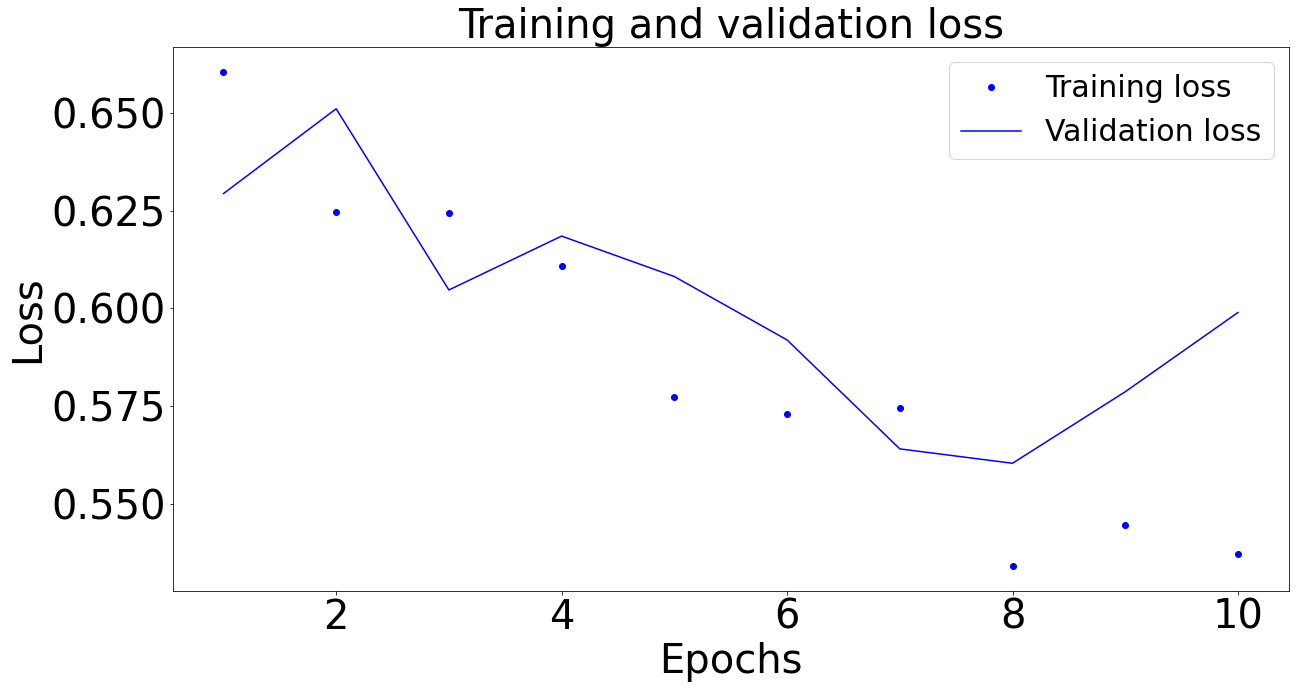

In [55]:
## Check performance on Validation data
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=40)
plt.xlabel('Epochs', fontsize=40)
plt.ylabel('Loss', fontsize=40)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)
plt.legend(fontsize=30)
plt.savefig('Val.png')
plt.show()


# Observation
From the above,  It did not perform too badly on the  validation data. Training can be stopped in the 8th epoch. to prevent overfitting.


## NB: 
The since I used crossvalidation, My test and training were handled automatically. The data which my model has not seen in this case is the validation data.

In [61]:
# Get confusion matrix
y_val_pred = (model.predict(X_val) > 0.5).astype("int32")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

[[147  21]
 [ 59  31]]


## Improve

### Choose only between 400 and 700 mins
This model did badly in the minority group. Let us see if it can be made better:

From the graph we plotted earlier, we can notice that the major difference between both groups occured between 400th and 700th minutes as seen below.

I will use this group only. This is to reduce training time and increase my number of epochs


In [62]:
# get condition data between 400th and 700th minute.,
condition = get_data(folder='condition', start=400, stop=700, label=1)
X_condition = condition[0]
y_condition = condition[1]

# get control data, Choose only between 300 and 600 mins
control = get_data(folder='control', start=400, stop=700, label=0)
X_control = control[0]
y_control = control[1]


# Mix both data set together
X_condition.extend(X_control)
X = X_condition

y_condition.extend(y_control)
y = y_condition

# Combine then and shuffle randomly
combinedDict = list(zip(X, y))
random.Random(seed).shuffle(combinedDict)
X[:], y[:] = zip(*combinedDict)

# Conveert the results into a numpy float32 number suitable for deep learning
X = np.array(X, dtype='float32')
y = np.array(y, dtype='float32')

# I want the shape (number of samples, number of minutes per day, number of features(that is single column))
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

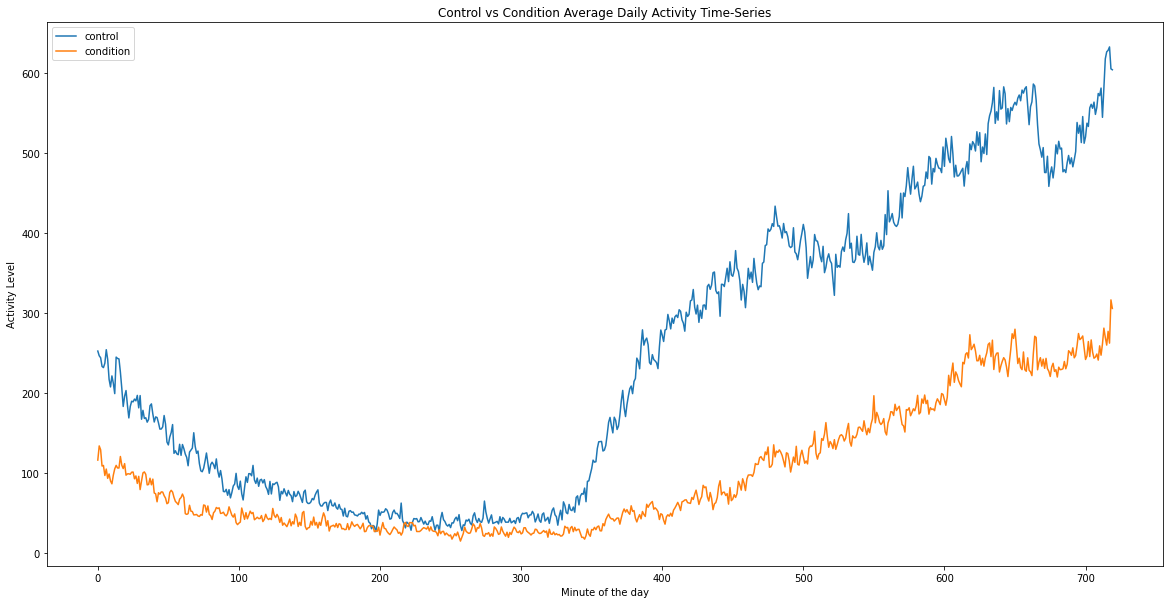

In [63]:
control_sum_vector = X_control_night[0]
for x in range(1, len(X_control_night)):
    control_sum_vector += X_control_night[x]
control_sum_vector = control_sum_vector / len(X_control_night)

plt.figure(figsize=(20, 10))
plt.plot(control_sum_vector, label='control')
plt.plot(condition_avg_vector, label='condition')
plt.title('Control vs Condition Average Daily Activity Time-Series')
plt.ylabel('Activity Level')
plt.xlabel('Minute of the day')
plt.legend()
plt.grid(False)
plt.savefig('Control vs Condition Average Daily Activity Time-Series.png')
plt.show()

In [63]:
# initialise container variables for my metrics
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
accuracy_scores = []
prec_scores = []
rec_scores = []
mcc_scores = []
f1_scores = []

# Firstly, I split to get validation data. the validation data is to enable me visualise and 
#  evaluate my model.
X_data, X_val, y_data, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

# Using cross-validation below, the kfold.split() function further splits my data into testing
# and training while keeping my validation data.

for train, test in kfold.split(X_data, y_data):
    model = Sequential()
    model.add(LSTM(128, input_shape=(300, 1), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', recall_m, precision_m, matthews_correlation, f1_m])
    
    history = model.fit(X_data[train], y_data[train], epochs=30, batch_size=64, validation_data=(X_val, y_val), verbose=0)
    scores = model.evaluate(X_data[test], y_data[test], verbose=0)
    
    print("%s: %.3f" % (model.metrics_names[1], scores[1]))
    print("%s: %.3f" % (model.metrics_names[2], scores[2]))
    print("%s: %.3f" % (model.metrics_names[3], scores[3]))
    print("%s: %.3f" % (model.metrics_names[4], scores[4]))
    print("%s: %.3f" % (model.metrics_names[5], scores[5]))
    print("\n")
    accuracy_scores.append(scores[1] * 100)
    prec_scores.append(scores[2])
    rec_scores.append(scores[3])
    mcc_scores.append(scores[4])
    f1_scores.append(scores[5])
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(prec_scores), np.std(prec_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(rec_scores), np.std(rec_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(mcc_scores), np.std(mcc_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(f1_scores), np.std(f1_scores)))

accuracy: 0.744
recall_m: 0.589
precision_m: 0.553
matthews_correlation: 0.349
f1_m: 0.556


accuracy: 0.792
recall_m: 0.850
precision_m: 0.704
matthews_correlation: 0.615
f1_m: 0.753


accuracy: 0.740
recall_m: 0.485
precision_m: 0.683
matthews_correlation: 0.405
f1_m: 0.566


accuracy: 0.675
recall_m: 0.114
precision_m: 0.417
matthews_correlation: 0.126
f1_m: 0.176


accuracy: 0.740
recall_m: 0.506
precision_m: 0.757
matthews_correlation: 0.462
f1_m: 0.605


accuracy: 0.688
recall_m: 0.579
precision_m: 0.541
matthews_correlation: 0.320
f1_m: 0.556


accuracy: 0.688
recall_m: 0.531
precision_m: 0.596
matthews_correlation: 0.344
f1_m: 0.560


accuracy: 0.714
recall_m: 0.303
precision_m: 0.433
matthews_correlation: 0.177
f1_m: 0.356


accuracy: 0.753
recall_m: 0.198
precision_m: 0.667
matthews_correlation: 0.293
f1_m: 0.295


accuracy: 0.727
recall_m: 0.605
precision_m: 0.685
matthews_correlation: 0.458
f1_m: 0.635


72.63% (+/- 3.37%)
0.48% (+/- 0.21)
0.60% (+/- 0.11)
0.35% (+/- 0.13)


The metrics did not improve much. Let me view the model loss graph

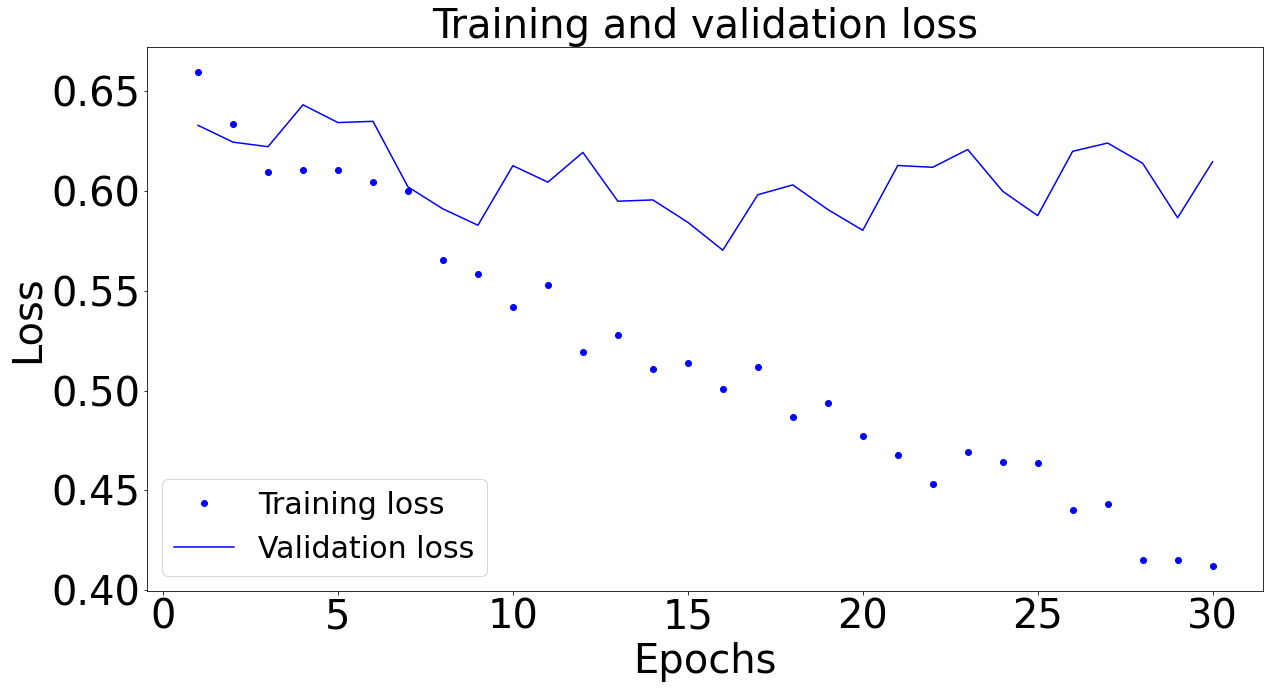

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=40)
plt.xlabel('Epochs', fontsize=40)
plt.ylabel('Loss', fontsize=40)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)
plt.legend(fontsize=30)
plt.savefig('Val.png')
plt.show()


## From the above, it can be seen that while the model continues getting better on the training data, the validation data performs badly. The model is over fitted. A remedy is to drop out some perceptrons or reduce the number of epochs.

# Drop_out

In [67]:
Dropout(rate=0.2)

# initialise container variables for my metrics
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
accuracy_scores = []
prec_scores = []
rec_scores = []
mcc_scores = []
f1_scores = []

# Firstly, I split to get validation data. the validation data is to enable me visualise and 
#  evaluate my model.
X_data, X_val, y_data, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

# Using cross-validation below, the kfold.split() function further splits my data into testing
# and training while keeping my validation data.
print(("="*30) + "Drop out" + ("="*30))
for train, test in kfold.split(X_data, y_data):
    model = Sequential()
    model.add(LSTM(128, input_shape=(300, 1), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', recall_m, precision_m, matthews_correlation, f1_m])
    
    history = model.fit(X_data[train], y_data[train], epochs=30, batch_size=64, validation_data=(X_val, y_val), verbose=0)
    scores = model.evaluate(X_data[test], y_data[test], verbose=0)
    
    print("%s: %.3f" % (model.metrics_names[1], scores[1]))
    print("%s: %.3f" % (model.metrics_names[2], scores[2]))
    print("%s: %.3f" % (model.metrics_names[3], scores[3]))
    print("%s: %.3f" % (model.metrics_names[4], scores[4]))
    print("%s: %.3f" % (model.metrics_names[5], scores[5]))
    print("\n")
    accuracy_scores.append(scores[1] * 100)
    prec_scores.append(scores[2])
    rec_scores.append(scores[3])
    mcc_scores.append(scores[4])
    f1_scores.append(scores[5])
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(prec_scores), np.std(prec_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(rec_scores), np.std(rec_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(mcc_scores), np.std(mcc_scores)))
print("%.2f%% (+/- %.2f)" % (np.mean(f1_scores), np.std(f1_scores)))

==============Drop out==============
accuracy: 0.744
recall_m: 0.563
precision_m: 0.552
matthews_correlation: 0.345
f1_m: 0.551


accuracy: 0.753
recall_m: 0.689
precision_m: 0.644
matthews_correlation: 0.442
f1_m: 0.659


accuracy: 0.779
recall_m: 0.601
precision_m: 0.767
matthews_correlation: 0.521
f1_m: 0.641


accuracy: 0.636
recall_m: 0.258
precision_m: 0.444
matthews_correlation: 0.104
f1_m: 0.324


accuracy: 0.740
recall_m: 0.461
precision_m: 0.647
matthews_correlation: 0.352
f1_m: 0.525


accuracy: 0.636
recall_m: 0.663
precision_m: 0.508
matthews_correlation: 0.304
f1_m: 0.561


accuracy: 0.740
recall_m: 0.597
precision_m: 0.622
matthews_correlation: 0.407
f1_m: 0.598


accuracy: 0.740
recall_m: 0.342
precision_m: 0.533
matthews_correlation: 0.308
f1_m: 0.416


accuracy: 0.714
recall_m: 0.282
precision_m: 0.542
matthews_correlation: 0.228
f1_m: 0.367


accuracy: 0.727
recall_m: 0.638
precision_m: 0.642
matthews_correlation: 0.426
f1_m: 0.635


72.11% (+/- 4.52%)
0.51% (+/- 0.1

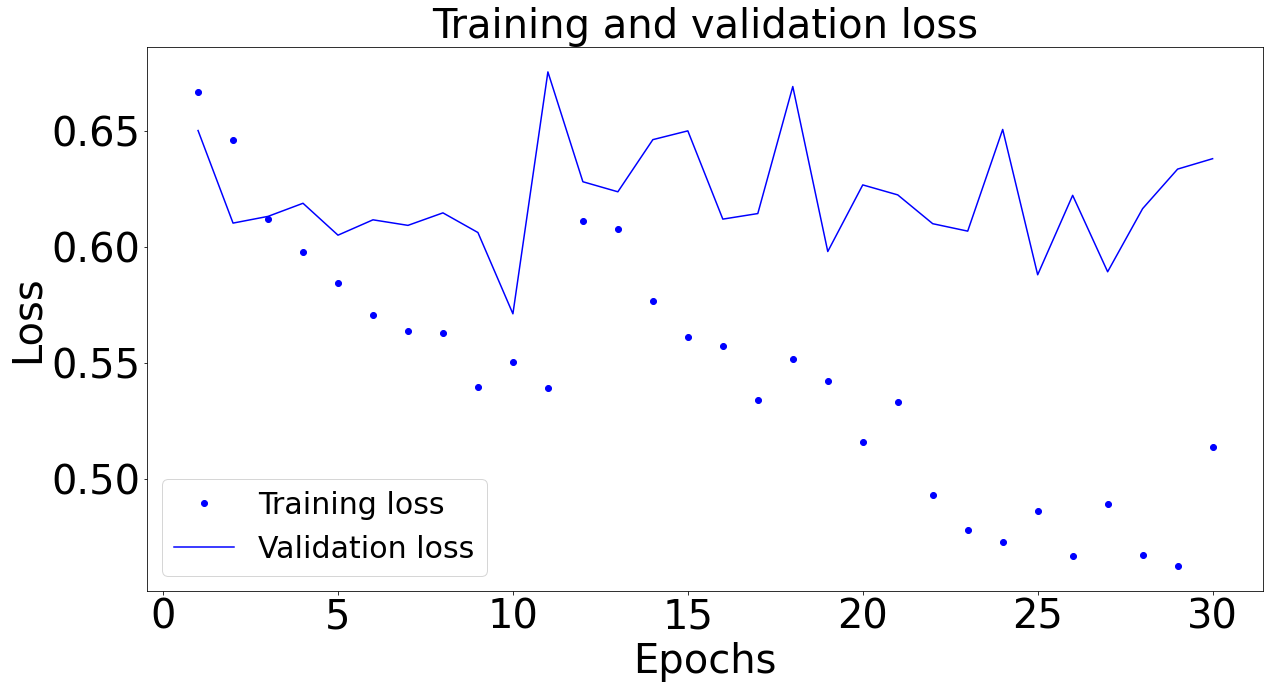

In [69]:
plt.figure(figsize=(20, 10))
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=40)
plt.xlabel('Epochs', fontsize=40)
plt.ylabel('Loss', fontsize=40)
plt.rc('xtick',labelsize=40)
plt.rc('ytick',labelsize=40)
plt.legend(fontsize=30)
plt.savefig('Val.png')
plt.show()


### From the look of things, there doesn't seem to be a strong relationship between the validation data and the training data.  It has a lot of spikes and shows too much randomness. 